In [1]:
from dataset import *
from train import *
from utils import torch_fix_seed

In [2]:
torch_fix_seed(19981303)

In [17]:
top_k_candidates = (20, 30, 40)
k = 7
temps = 0.7
momentums = 0.99
k_value = 64

def get_self_pretrain_model(index=1000):
    base_encoder = torchvision.models.resnet50(weights=None)
    base_encoder.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    origin_dim_mlp = base_encoder.fc.in_features
    base_encoder.fc = None
    temp = torch.load(f'./checkpoints/CEM_ALL_CHECK_{index}_Epoch.pth')['state_dict']
    state_dict = {}
    for k, v in temp.items():
        if 'encoder_q' in k:
            if 'fc' not in k:
                state_dict['.'.join(k.split('.')[1:])] = v
    base_encoder.load_state_dict(state_dict)
    base_encoder.fc = torch.nn.Linear(origin_dim_mlp, 512)
    return base_encoder

In [18]:
parameters = {'pretrain_model': ['self_pretrained']}
train_metrics = HistoryRecorder(['Train Loss', 'Train Acc', 'Val Loss', 'Val Acc'], list(parameters.keys()))

parameters = list(itertools.product(*parameters.values()))

for parameter in parameters:

    ### custom part to get parameters
    pretrain_model = parameter[0]
    ### END
    
    for images in k_fold_train_validation_split(ORIGINAL_IMAGE, TARGET_IMAGE, k):
        train_dataset = SingleChannelNDIDatasetContrastiveLearningWithAug(images, False)
        val_dataset = SingleChannelNDIDatasetContrastiveLearningWithAug(images, True)
        train_iter = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
        val_iter = DataLoader(val_dataset, batch_size=len(val_dataset))

        model = get_self_pretrain_model(index=900)
        model = RetrievalModel(model)
        model = model.cuda()
            
        device = torch.device('cuda:0')
        optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
        start_time = time.time()
        metrics = train_moco_return_metrics_top_k(model, train_iter, val_iter, optimizer, 15, device,
                                                    tested_parameter=parameter, k_candidates=top_k_candidates, scheduler=scheduler)
        end_time = time.time()
        train_metrics.cal_add(metrics)
train_metrics.cal_divide(k)

Epoch 1, Train_Loss 2.578875017166138, Val_loss 3.2727203369140625
Train_acc_top_20 0.1562	Train_acc_top_30 0.1875	Train_acc_top_40 0.25	
Val_acc_top_20 0.0	Val_acc_top_30 0.12	Val_acc_top_40 0.17	
Epoch 2, Train_Loss 1.584114670753479, Val_loss 4.04317045211792
Train_acc_top_20 0.1187	Train_acc_top_30 0.1688	Train_acc_top_40 0.2313	
Val_acc_top_20 0.0	Val_acc_top_30 0.04	Val_acc_top_40 0.08	
Epoch 3, Train_Loss 1.3016432642936706, Val_loss 4.457634449005127
Train_acc_top_20 0.1187	Train_acc_top_30 0.1875	Train_acc_top_40 0.2375	
Val_acc_top_20 0.0	Val_acc_top_30 0.0	Val_acc_top_40 0.08	
Epoch 4, Train_Loss 1.0484171688556672, Val_loss 3.8620975017547607
Train_acc_top_20 0.1187	Train_acc_top_30 0.1688	Train_acc_top_40 0.2687	
Val_acc_top_20 0.0	Val_acc_top_30 0.04	Val_acc_top_40 0.17	
Epoch 5, Train_Loss 0.9718488097190857, Val_loss 3.6033239364624023
Train_acc_top_20 0.2562	Train_acc_top_30 0.35	Train_acc_top_40 0.4188	
Val_acc_top_20 0.25	Val_acc_top_30 0.42	Val_acc_top_40 0.5	
Epoch

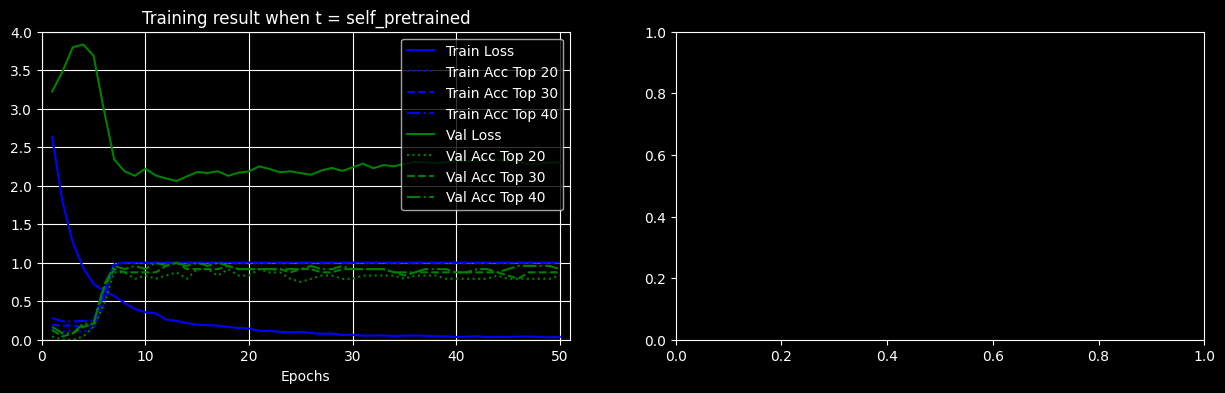

('self_pretrained',) 20 mean 0.8104166666666666
('self_pretrained',) 20 max 0.9166666666666666
('self_pretrained',) 30 mean 0.8729166666666668
('self_pretrained',) 30 max 1.0
('self_pretrained',) 40 mean 0.9125
('self_pretrained',) 40 max 1.0


<Figure size 640x480 with 0 Axes>

In [15]:
# lr 5e-3

draw_graph(train_metrics.data, 50, ('tok_ks'))
for k, v in train_metrics.data.items():
    for k1 in v[1].keys():
        print(f'{k} {k1} mean {np.mean(v[3][k1][-20:])}')
        print(f'{k} {k1} max {np.max(v[3][k1])}')

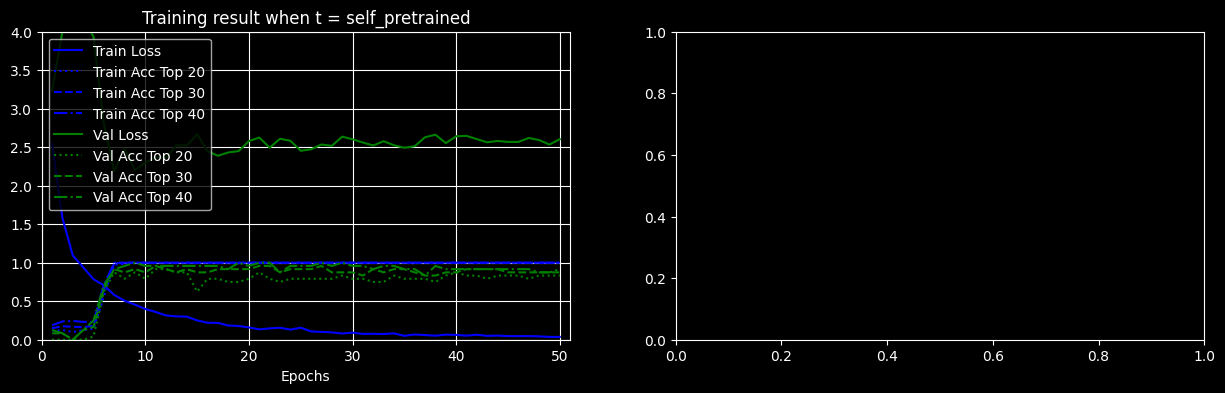

('self_pretrained',) 20 mean 0.8104166666666666
('self_pretrained',) 20 max 0.9166666666666666
('self_pretrained',) 30 mean 0.8833333333333334
('self_pretrained',) 30 max 0.9583333333333334
('self_pretrained',) 40 mean 0.9166666666666666
('self_pretrained',) 40 max 1.0


<Figure size 640x480 with 0 Axes>

In [18]:
# lr 1e-2

draw_graph(train_metrics.data, 50, ('tok_ks'))
for k, v in train_metrics.data.items():
    for k1 in v[1].keys():
        print(f'{k} {k1} mean {np.mean(v[3][k1][-20:])}')
        print(f'{k} {k1} max {np.max(v[3][k1])}')

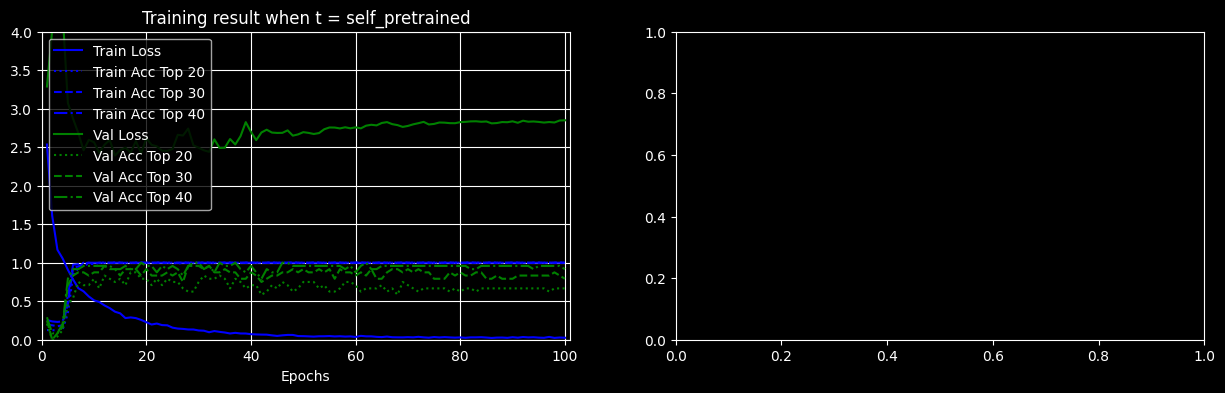

('self_pretrained',) 20 mean 0.6624999999999999
('self_pretrained',) 20 max 0.875
('self_pretrained',) 30 mean 0.8270833333333334
('self_pretrained',) 30 max 0.9583333333333334
('self_pretrained',) 40 mean 0.95
('self_pretrained',) 40 max 1.0


<Figure size 640x480 with 0 Axes>

In [6]:
# lr 0.02

draw_graph(train_metrics.data, 100, ('tok_ks'))
for k, v in train_metrics.data.items():
    for k1 in v[1].keys():
        print(f'{k} {k1} mean {np.mean(v[3][k1][-20:])}')
        print(f'{k} {k1} max {np.max(v[3][k1])}')

In [24]:
top_k_candidates = (10, 20, 30)
k = 7
temps = 0.7
momentums = 0.99
k_value = 64
parameters = {'epochs_pretrain_model': list(range(100, 1100, 100))}
# parameters = {'pretrain_model': ['self_pretrained', 'CEM', 'ImageNet', 'None']}
# parameters = {'pretrain_model': ['CEM']}
train_metrics = HistoryRecorder(['Train Loss', 'Train Acc', 'Val Loss', 'Val Acc'], list(parameters.keys()))
parameters = list(itertools.product(*parameters.values()))

for i, parameter in enumerate(parameters):

    ### custom part to get parameters
    pretrain_model = parameter[0]
    ### END
    
    for j, images in enumerate(k_fold_train_validation_split(ORIGINAL_IMAGE, TARGET_IMAGE, k)):
        train_dataset = SingleChannelNDIDatasetContrastiveLearningWithAug(images, False)
        val_dataset = SingleChannelNDIDatasetContrastiveLearningWithAug(images, True)
        train_iter = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
        val_iter = DataLoader(val_dataset, batch_size=len(val_dataset))

        model = get_self_pretrain_model(index=pretrain_model)
        model = RetrievalModel(model)
        model = model.cuda()
        
        
        device = torch.device('cuda:0')
        optimizer = torch.optim.SGD(model.parameters(), lr=5e-3, momentum=0.9, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
        start_time = time.time()
        print(f'Parameter Index: {i} / {len(parameters)}, Fold Index: {j} / {k}')
        metrics = train_moco_return_metrics_top_k(model, train_iter, val_iter, optimizer, 30, device,
                                                    tested_parameter=parameter, k_candidates=top_k_candidates, scheduler=scheduler)
        end_time = time.time()
        train_metrics.cal_add(metrics)
train_metrics.cal_divide(k)

Parameter Index: 0 / 10, Fold Index: 0 / 7
Epoch 1, Train_Loss 2.735195755958557, Val_loss 3.2526681423187256
Train_acc_top_10 0.0437	Train_acc_top_20 0.125	Train_acc_top_30 0.2125	
Val_acc_top_10 0.17	Val_acc_top_20 0.21	Val_acc_top_30 0.33	
Epoch 2, Train_Loss 1.7835879921913147, Val_loss 3.285694122314453
Train_acc_top_10 0.0625	Train_acc_top_20 0.125	Train_acc_top_30 0.1938	
Val_acc_top_10 0.0	Val_acc_top_20 0.0	Val_acc_top_30 0.0	
Epoch 3, Train_Loss 1.2346712291240691, Val_loss 3.5333046913146973
Train_acc_top_10 0.0563	Train_acc_top_20 0.125	Train_acc_top_30 0.1812	
Val_acc_top_10 0.0	Val_acc_top_20 0.0	Val_acc_top_30 0.04	
Epoch 4, Train_Loss 0.8604467153549195, Val_loss 3.863070249557495
Train_acc_top_10 0.0688	Train_acc_top_20 0.125	Train_acc_top_30 0.175	
Val_acc_top_10 0.0	Val_acc_top_20 0.0	Val_acc_top_30 0.0	
Epoch 5, Train_Loss 0.6507158190011978, Val_loss 3.6656315326690674
Train_acc_top_10 0.075	Train_acc_top_20 0.1562	Train_acc_top_30 0.2812	
Val_acc_top_10 0.0	Val_ac

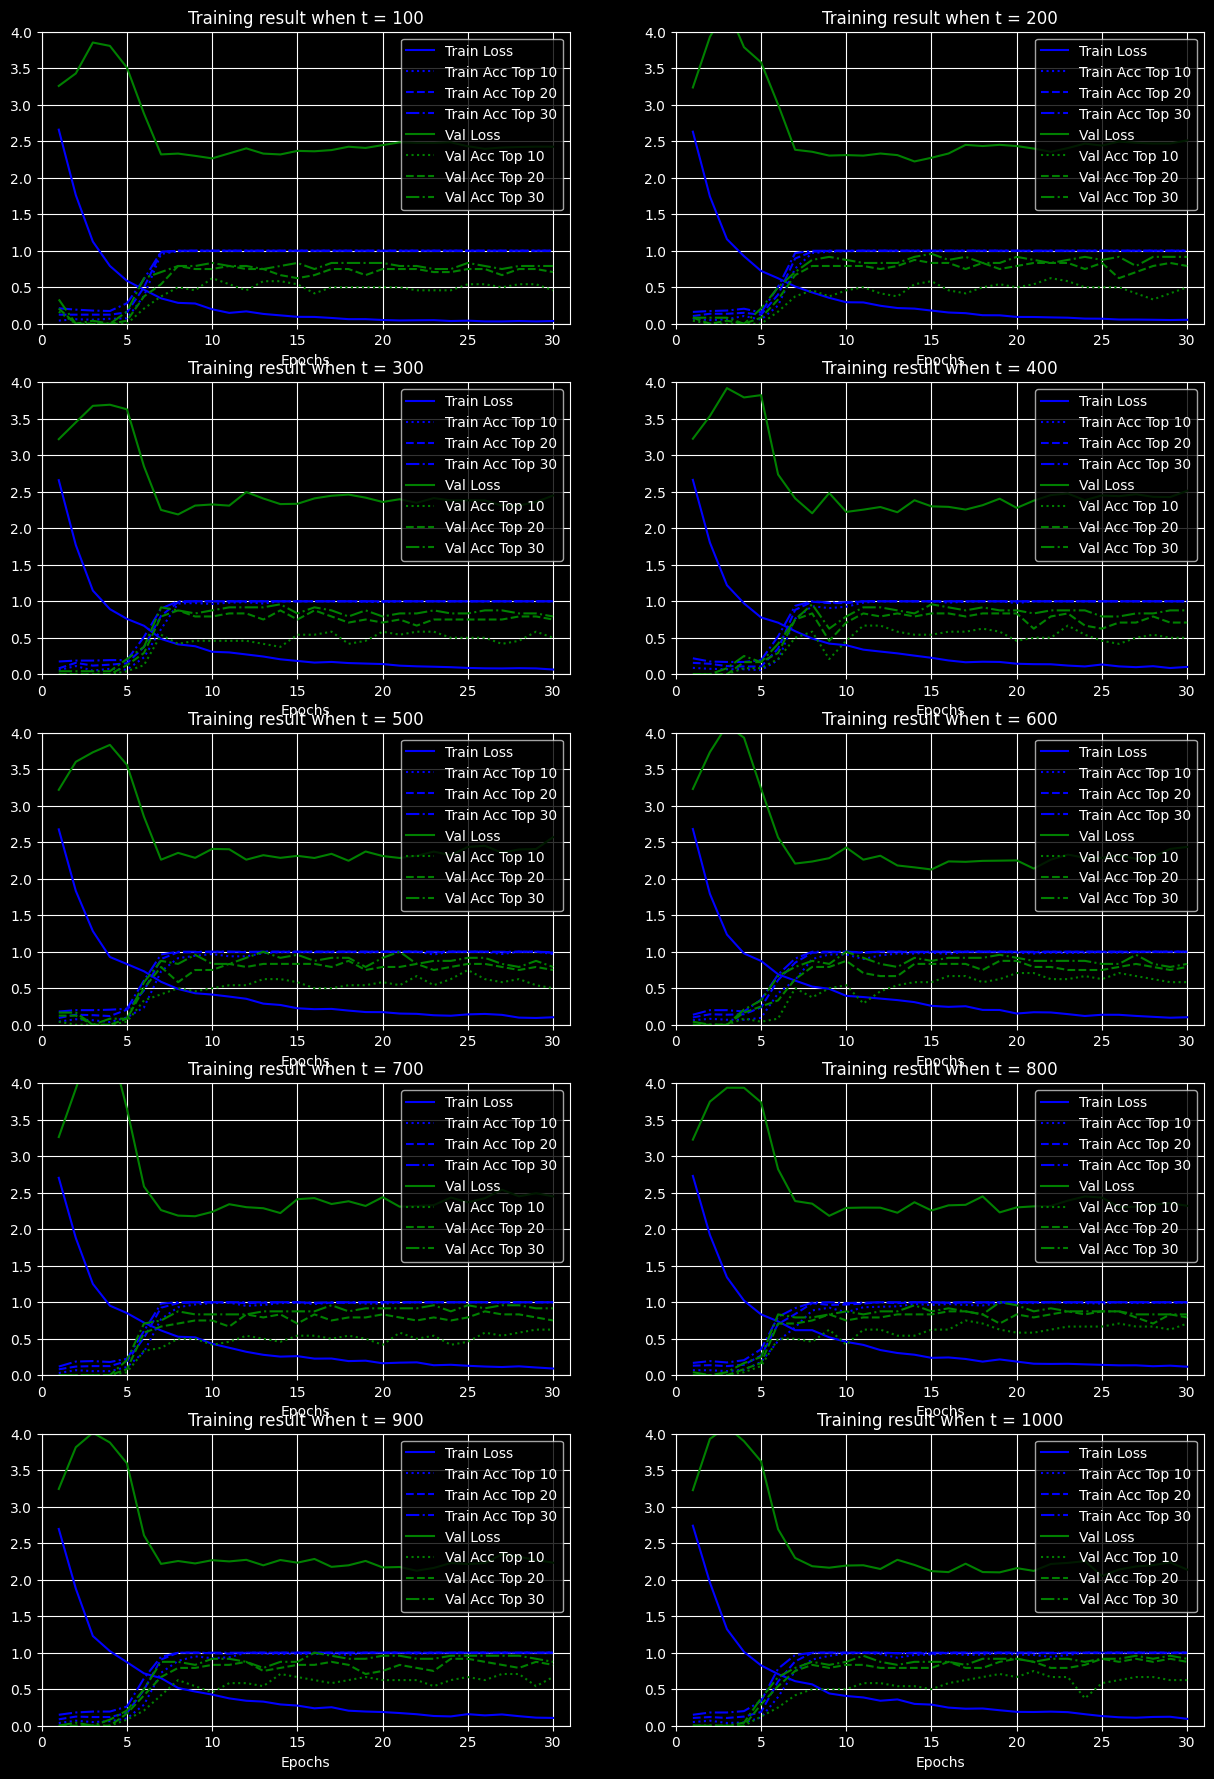

(100,) 10 mean 0.5062499999999999
(100,) 10 max 0.625
(100,) 20 mean 0.7229166666666667
(100,) 20 max 0.7916666666666666
(100,) 30 mean 0.79375
(100,) 30 max 0.8333333333333334
(200,) 10 mean 0.48749999999999993
(200,) 10 max 0.625
(200,) 20 mean 0.7916666666666666
(200,) 20 max 0.875
(200,) 30 mean 0.8791666666666667
(200,) 30 max 0.9583333333333334
(300,) 10 mean 0.5
(300,) 10 max 0.5833333333333334
(300,) 20 mean 0.7687499999999999
(300,) 20 max 0.875
(300,) 30 mean 0.8604166666666668
(300,) 30 max 0.9583333333333334
(400,) 10 mean 0.5479166666666666
(400,) 10 max 0.6666666666666666
(400,) 20 mean 0.76875
(400,) 20 max 0.8333333333333334
(400,) 30 mean 0.8708333333333333
(400,) 30 max 0.9583333333333334
(500,) 10 mean 0.5791666666666666
(500,) 10 max 0.75
(500,) 20 mean 0.8041666666666666
(500,) 20 max 0.875
(500,) 30 mean 0.8875
(500,) 30 max 1.0
(600,) 10 mean 0.6062500000000001
(600,) 10 max 0.7083333333333334
(600,) 20 mean 0.7833333333333333
(600,) 20 max 0.875
(600,) 30 mean 0

<Figure size 640x480 with 0 Axes>

In [26]:
# 100 - 1000 epoch训练模型测试

draw_graph(train_metrics.data, 30, ('tok_ks'))
for k, v in train_metrics.data.items():
    for k1 in v[1].keys():
        print(f'{k} {k1} mean {np.mean(v[3][k1][10:])}')
        print(f'{k} {k1} max {np.max(v[3][k1])}')

In [12]:
def get_self_pretrain_model(index=1000):
    base_encoder = torchvision.models.resnet50(weights=None)
    base_encoder.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    origin_dim_mlp = base_encoder.fc.in_features
    base_encoder.fc = None
    temp = torch.load(f'./checkpoints/CEM_ALL_CHECK_{index}_Epoch.pth')['state_dict']
    state_dict = {}
    for k, v in temp.items():
        if 'encoder_q' in k:
            if 'fc' not in k:
                state_dict['.'.join(k.split('.')[1:])] = v
    base_encoder.load_state_dict(state_dict)
    base_encoder.fc = torch.nn.Linear(origin_dim_mlp, 512)
    return base_encoder

def get_pretrain_model():
    base_encoder = torchvision.models.resnet50(weights=None)
    base_encoder.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    origin_dim_mlp = base_encoder.fc.in_features
    base_encoder.fc = None
    base_encoder.load_state_dict(torch.load('../../GithubProject/cem-dataset/cem1.5m_swav_resnet50_200ep_balanced.pth.tar')['state_dict'])
    base_encoder.fc = torch.nn.Linear(origin_dim_mlp, 512)
    return base_encoder

def get_model(keyword):
    if keyword == 'self_pretrained':
        return get_self_pretrain_model(index=900)
    if keyword == 'CEM':
        return get_pretrain_model()
    if keyword == 'ImageNet':
        model = torchvision.models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        origin_dim_mlp = model.fc.in_features
        model.fc = torch.nn.Linear(origin_dim_mlp, 512)
        return model
    if keyword == 'None':
        model = torchvision.models.resnet50(weights=None)
        model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        origin_dim_mlp = model.fc.in_features
        model.fc = torch.nn.Linear(origin_dim_mlp, 512)
        return model

In [11]:
model = torchvision.models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [13]:
top_k_candidates = (10, 20, 30)
k = 7
temps = 0.7
momentums = 0.99
k_value = 64

parameters = {'pretrain_model': ['self_pretrained', 'CEM', 'ImageNet', 'None']}
# parameters = {'pretrain_model': ['self_pretrained']}
train_metrics = HistoryRecorder(['Train Loss', 'Train Acc', 'Val Loss', 'Val Acc'], list(parameters.keys()))

parameters = list(itertools.product(*parameters.values()))

for parameter in parameters:

    ### custom part to get parameters
    pretrain_model = parameter[0]
    ### END
    
    for images in k_fold_train_validation_split(ORIGINAL_IMAGE, TARGET_IMAGE, k):
        train_dataset = SingleChannelNDIDatasetContrastiveLearningWithAug(images, False)
        val_dataset = SingleChannelNDIDatasetContrastiveLearningWithAug(images, True)
        train_iter = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
        val_iter = DataLoader(val_dataset, batch_size=len(val_dataset))

        model = get_model(pretrain_model)
        model = RetrievalModel(model)
        model = model.cuda()
        
        if pretrain_model in ['self_pretrained', 'CEM', 'ImageNet']:
            lr = 5e-3
        else:
            lr = 2e-2
            
        device = torch.device('cuda:0')
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
        start_time = time.time()
        metrics = train_moco_return_metrics_top_k(model, train_iter, val_iter, optimizer, 30, device,
                                                    tested_parameter=parameter, k_candidates=top_k_candidates, scheduler=scheduler)
        end_time = time.time()
        train_metrics.cal_add(metrics)
train_metrics.cal_divide(k)

Epoch 1, Train_Loss 2.747504639625549, Val_loss 3.1819827556610107
Train_acc_top_10 0.0688	Train_acc_top_20 0.125	Train_acc_top_30 0.1812	
Val_acc_top_10 0.0	Val_acc_top_20 0.0	Val_acc_top_30 0.0	
Epoch 2, Train_Loss 1.8467784881591798, Val_loss 3.4577112197875977
Train_acc_top_10 0.075	Train_acc_top_20 0.125	Train_acc_top_30 0.175	
Val_acc_top_10 0.0	Val_acc_top_20 0.0	Val_acc_top_30 0.0	
Epoch 3, Train_Loss 1.1566745340824127, Val_loss 4.070369720458984
Train_acc_top_10 0.0563	Train_acc_top_20 0.1187	Train_acc_top_30 0.2	
Val_acc_top_10 0.0	Val_acc_top_20 0.0	Val_acc_top_30 0.0	
Epoch 4, Train_Loss 0.8775870501995087, Val_loss 3.713338851928711
Train_acc_top_10 0.0625	Train_acc_top_20 0.125	Train_acc_top_30 0.1875	
Val_acc_top_10 0.0	Val_acc_top_20 0.04	Val_acc_top_30 0.04	
Epoch 5, Train_Loss 0.8740104973316193, Val_loss 4.323258399963379
Train_acc_top_10 0.0688	Train_acc_top_20 0.1125	Train_acc_top_30 0.1875	
Val_acc_top_10 0.08	Val_acc_top_20 0.21	Val_acc_top_30 0.29	
Epoch 6, Tra

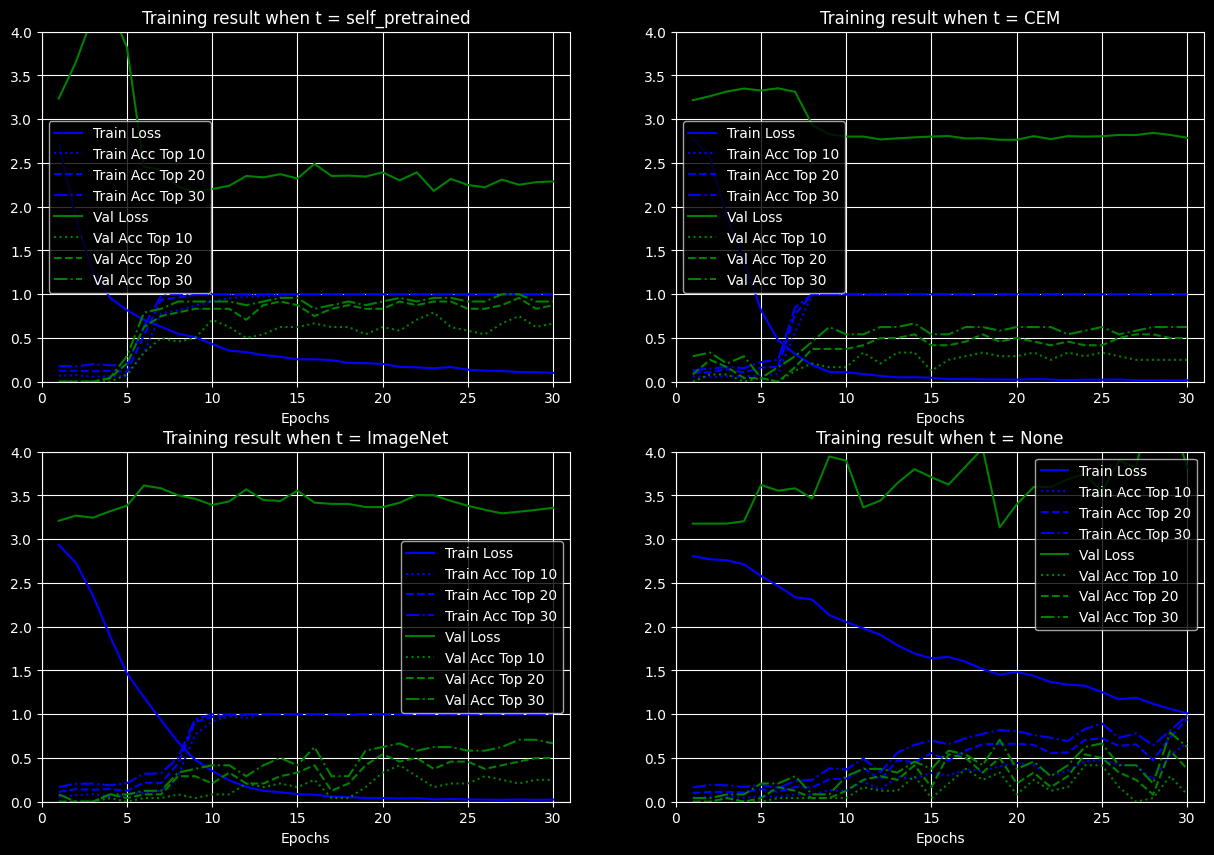

('self_pretrained',) 10 mean 0.5833333333333333
('self_pretrained',) 10 max 0.7083333333333334
('self_pretrained',) 20 mean 0.8416666666666668
('self_pretrained',) 20 max 0.9166666666666666
('self_pretrained',) 30 mean 0.925
('self_pretrained',) 30 max 0.9583333333333334
('CEM',) 10 mean 0.26666666666666666
('CEM',) 10 max 0.3333333333333333
('CEM',) 20 mean 0.475
('CEM',) 20 max 0.5416666666666666
('CEM',) 30 mean 0.5999999999999999
('CEM',) 30 max 0.6666666666666666
('ImageNet',) 10 mean 0.16666666666666669
('ImageNet',) 10 max 0.20833333333333334
('ImageNet',) 20 mean 0.275
('ImageNet',) 20 max 0.3333333333333333
('ImageNet',) 30 mean 0.4083333333333333
('ImageNet',) 30 max 0.5
('None',) 10 mean 0.14999999999999997
('None',) 10 max 0.2916666666666667
('None',) 20 mean 0.275
('None',) 20 max 0.4166666666666667
('None',) 30 mean 0.3833333333333333
('None',) 30 max 0.4583333333333333


<Figure size 640x480 with 0 Axes>

In [15]:
draw_graph(train_metrics.data, 30, ('tok_ks'))
for k, v in train_metrics.data.items():
    for k1 in v[1].keys():
        print(f'{k} {k1} mean {np.mean(v[3][k1][10:15])}')
        print(f'{k} {k1} max {np.max(v[3][k1][:15])}')